In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import sys
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v6 import Autoencoder
from tools.GRU_SingleStep_v11 import RNN_GRU
# from tools.LSTM_SingleStep_v2 import RNN_GRU
# from tools.SimpleRNN_SingleStep_v2 import RNN_GRU

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-01-22 07:21:01.824252: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 07:21:01.824587: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 07:21:01.857627: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 07:21:01.857967: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 07:21:01.858250: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print('')
print(tf.config.list_logical_devices())
print('')
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]

2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # making RNN save directory
    dir_name_rnn = os.getcwd() + dir_sep + 'saved_rnn'
    if not os.path.isdir(dir_name_rnn):
        os.makedirs(dir_name_rnn)

    counter = 0
    while True:
        dir_check = 'rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_rnn = dir_name_rnn + dir_sep + dir_check
    os.makedirs(dir_name_rnn)
    os.makedirs(dir_name_rnn+dir_sep+'plots')

    # whether to use AE data or just work on raw data
    use_ae_data = False # if false, specifying ae_idx will only show which dataset to use

    # autoencoder directory
    ae_idx = '043'
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx
else:
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_015'

    # reading AE directory
    with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))

    try:
        use_ae_data = params_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in sim_data_AE_params, set to True.")
        normalize_dataset = True
    
    dir_name_ae = params_dict['dir_name_ae']
    ae_idx = dir_name_ae[-3:]
    dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx

    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    T_sample_input = params_rnn_dict['T_sample_input']
    T_sample_output = params_rnn_dict['T_sample_output']
    T_offset = params_rnn_dict['T_offset']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in RNN_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
    try:
        dense_layer_act_func = params_rnn_dict['dense_layer_act_func']
    except:
        print("'dense_layer_act_func' not present in RNN_specific_data, set to 'linear'.")
        dense_layer_act_func = 'linear'
    try:
        stateful = params_rnn_dict['stateful']
    except:
        print("'stateful' not present in RNN_specific_data, set to True.")
        stateful = True
    try:
        use_learnable_state = params_rnn_dict['use_learnable_state']
    except:
        print("'use_learnable_state' not present in RNN_specific_data, set to False.")
        use_learnable_state = False
    try:
        use_weights_post_dense = params_rnn_dict['use_weights_post_dense']
    except:
        print("'use_weights_post_dense' not present in RNN_specific_data, set to False.")
        use_weights_post_dense = False
    try:
        use_ae_data = params_rnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in RNN_specific_data, set to True.")
        use_ae_data = True

    

    normalization_arr = None
    try:
        with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
            lines = f.readlines()
        rnn_norm_arr_dict = eval(lines)
        normalization_arr = rnn_norm_arr_dict['normalization_arr']
    except:
        pass
    if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
        with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
            normalization_arr = fl['normalization_arr'][0]

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in ae_data, set to 'True'.")
    ae_data_with_params = True

if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data']
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065
dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_043
data_dir_idx: 005
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [14]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

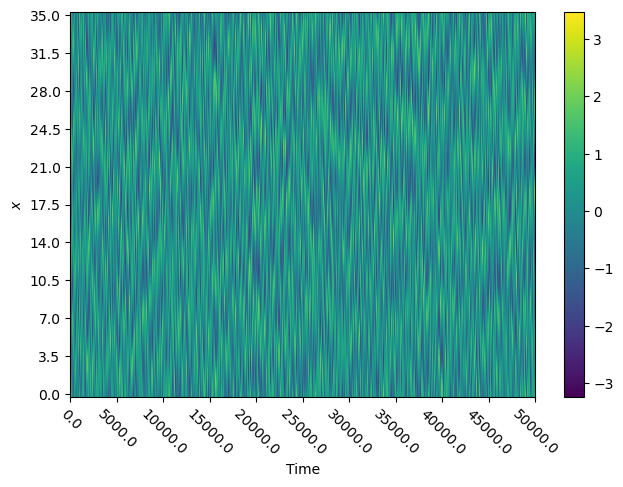

In [15]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

In [16]:
# dealing with normalizing the data before feeding into autoencoder
if use_ae_data == True:
    if normalizeforae_flag == True:
        for i in range(numpoints_xgrid):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]

    if ae_data_with_params == False:
        all_data = all_data[:, 0:numpoints_xgrid]
else:
    # using raw data, neglecting the params attached (if any)
    all_data = all_data[:, 0:numpoints_xgrid]

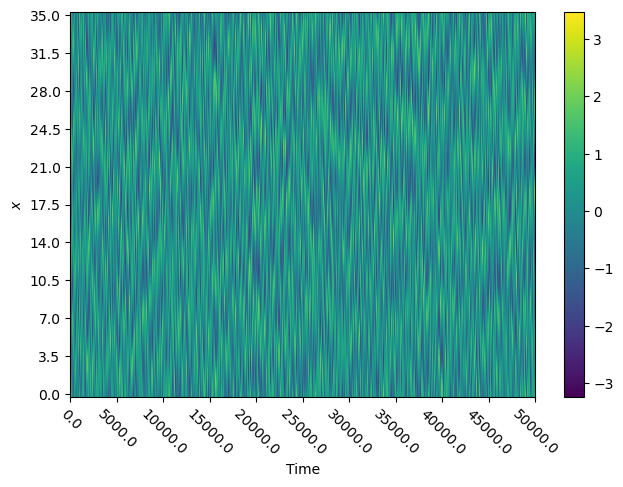

In [17]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

# Autoencoder

In [18]:
if use_ae_data == True:
    load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
    wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [19]:
if use_ae_data == True:
    ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
    ae_net.load_weights_from_file(wt_file)

In [20]:
# create data
if use_ae_data == True:
    latent_states_all = ae_net.encoder_net.predict(all_data)
    del(all_data)
else:
    latent_states_all = all_data
num_latent_states = latent_states_all.shape[1]

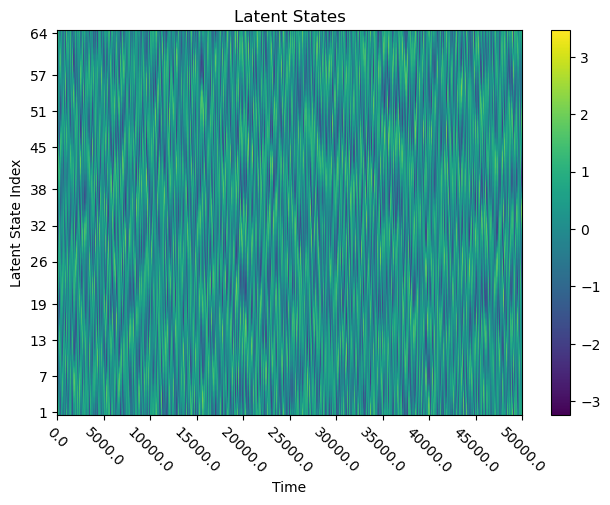

In [21]:
plot_latent_states_KS(
    boundary_idx_arr,
    latent_states_all,
    delta_t,
    dir_name_ae,
    xticks_snapto=int(40*np.round((T//10)/40)),
    num_yticks=11,
    save_figs=False)

In [22]:
# for i in range(ae_net.layers):
#     tf.keras.utils.plot_model(
#         ae_net.layers[i],
#         to_file=dir_name_ae+'/plots/netlayer_{}.png'.format(i),
#         show_shapes=True,
#         dpi=300
# )

# GRU

In [23]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = 5 # int(5000/np.mean(lyapunov_time_arr))#
    dt_rnn = 0.2
    T_sample_input = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = dt_rnn
    normalize_dataset = True # whether the data for the RNN should be normalized by the dataset's mean and std
    normalization_arr = None
    skip_intermediate = 'full sample'
    noise_type = 'normal' # can be 'uniform' or 'normal'

    # can be 'minmax', 'minmax2', 'stddev', or a list with
    # sequential order of any of these; if it is 'minmax'
    # then stddev_multiplier has no effect
    normalization_type = 'stddev'
    stddev_multiplier = 3

    dense_layer_act_func = ['tanh']
    use_weights_post_dense = True
    stateful = True
    use_learnable_state = False
    use_trainable_weights_with_reslayers = False
        
    if return_params_arr != False:
        params = params_arr
    else:
        params = None
        
    # timeMeanofSpaceRMS = np.mean(np.mean(latent_states_all**2, axis=1)**0.5)

    # saving simulation data
    sim_data = {
        'params_mat':params_mat,
        'init_state_mat':init_state_mat,
        't0':t0,
        'T':T,
        'delta_t':delta_t,
        'return_params_arr':return_params_arr,
        'dir_name_ae':dir_name_ae,
        'normalize_dataset':normalize_dataset,
        'stddev_multiplier':stddev_multiplier,
        'use_ae_data':use_ae_data,
    }


    with open(dir_name_rnn+dir_sep+'sim_data_AE_params.txt', 'w') as f:
        f.write(str(sim_data))
        
    # saving RNN specific data
    RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':RNN_GRU.__module__,
        'noise_type':noise_type,
        'normalization_type':normalization_type,
        'dense_layer_act_func':dense_layer_act_func,
        'stateful':stateful,
        'use_learnable_state':use_learnable_state,
        'use_weights_post_dense':use_weights_post_dense,
        'use_trainable_weights_with_reslayers':use_trainable_weights_with_reslayers,
    }

    with open(dir_name_rnn+dir_sep+'RNN_specific_data.txt', 'w') as f:
        f.write(str(RNN_specific_data))

In [24]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [25]:
temp = np.divide(latent_states_all-normalization_arr[0], normalization_arr[1])
time_stddev = np.std(temp, axis=0)
timeMeanofSpaceRMS = np.mean(np.mean(temp**2, axis=1)**0.5)
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)
del(temp)

In [26]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [1e-3, 1e-4, 1e-5]
    epochs = 1000
    patience = 10 # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 5e-7  # weight for regularizer
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 64
    fRMS = 2/100
    zoneout_rate = 0.0
    rnncell_dropout_rate = 0.0
    denselayer_dropout_rate = 0.0
    

    stddev = fRMS*timeMeanofSpaceRMS
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
        'stddev':stddev,
        'zoneout_rate':zoneout_rate,
        'rnncell_dropout_rate':rnncell_dropout_rate,
        'denselayer_dropout_rate':denselayer_dropout_rate,
    }

    with open(dir_name_rnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_rnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr],
    )
    
else:
    # dir_name_rnn_og = dir_name_rnn
    # dir_name_rnn_temp = '/home/rkaushik/Documents/Thesis/MLROM/CDV/saved_rnn/rnn_'+dir_name_rnn_og[-3:]
    # dir_name_rnn = dir_name_rnn_temp

    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()


    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [27]:
# idx = np.arange(data_rnn_input.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round(train_split*data_rnn_input.shape[0]))

# training_data_rnn_input = data_rnn_input[idx[0:boundary]]
# training_data_rnn_output = data_rnn_output[idx[0:boundary]]

# testing_data_rnn_input = data_rnn_input[idx[boundary:]]
# testing_data_rnn_output = data_rnn_output[idx[boundary:]]

In [28]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_val_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_test_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_samples_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
begin_idx = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
    num_train_arr[i] = batch_size * (int( (1-test_split-val_split)*num_samples )//batch_size)
    num_val_arr[i] = batch_size * (int(val_split*num_samples)//batch_size)
    num_test_arr[i] = batch_size * int((num_samples - num_train_arr[i] - num_val_arr[i])//batch_size)
    num_samples_arr[i] = num_train_arr[i] + num_val_arr[i] + num_test_arr[i]
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [np.sum(num_train_arr)]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [np.sum(num_train_arr)]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [np.sum(num_val_arr)]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [np.sum(num_val_arr)]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [np.sum(num_test_arr)]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [np.sum(num_test_arr)]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape)
training_data_rnn_output = np.empty(shape=training_output_shape)

val_data_rnn_input = np.empty(shape=val_input_shape)
val_data_rnn_output = np.empty(shape=val_output_shape)

testing_data_rnn_input = np.empty(shape=testing_input_shape)
testing_data_rnn_output = np.empty(shape=testing_output_shape)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    # num_samples = idx.shape[0]
    # num_train = int( (1-test_split-val_split)*num_samples )
    # num_val = int(val_split*num_samples)
    num_samples = num_samples_arr[i]
    num_train = num_train_arr[i]
    num_val = num_val_arr[i]
    num_test = num_test_arr[i]
    
    nbatches_train = num_train // batch_size
    nbatches_val = num_val // batch_size
    nbatches_test = num_test // batch_size

    for j in range(batch_size):
        training_data_rnn_input[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_input[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        training_data_rnn_output[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_output[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        
        val_data_rnn_input[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_input[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]
        val_data_rnn_output[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_output[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]

        testing_data_rnn_input[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_input[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]
        testing_data_rnn_output[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_output[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]


    # training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    # training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    # val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    # val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    # num_test = num_samples-num_train-num_val+1
    # testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_input[idx[num_train+num_val:]]
    # testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_output[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# cleaning up
del(data_rnn_input)
del(data_rnn_output)

# further shuffling
if stateful == False:
    idx = np.arange(0, training_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    training_data_rnn_input = training_data_rnn_input[idx]
    training_data_rnn_output = training_data_rnn_output[idx]

    idx = np.arange(0, val_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    val_data_rnn_input = val_data_rnn_input[idx]
    val_data_rnn_output = val_data_rnn_output[idx]

    idx = np.arange(0, testing_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    testing_data_rnn_input = testing_data_rnn_input[idx]
    testing_data_rnn_output = testing_data_rnn_output[idx]

    del(idx)

In [29]:
print('training_data_rnn_input.shape : ', training_data_rnn_input.shape)
print(' testing_data_rnn_input.shape : ', testing_data_rnn_input.shape)
print('     val_data_rnn_input.shape : ', val_data_rnn_input.shape)

training_data_rnn_input.shape :  (512, 387, 64)
 testing_data_rnn_input.shape :  (64, 387, 64)
     val_data_rnn_input.shape :  (64, 387, 64)


In [30]:
# print(rnn_data_boundary_idx_arr)

In [31]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
#     rnn_layers_units = [500]*3
#     scalar_weights = None
    # scalar_weights = [
    #     0.5, 
    #     0.0, 0.5,
    #     0.0, 0.0, 1.0,
    #     1/6, 1/3, 1/3, 1/6
    # ] # RK4
    # scalar_weights = [
    #     1.0,
    #     0.25, 0.25,
    #     1/6, 1/6, 2/3
    # ] # TVD RK3
    scalar_weights = [
        1.0,
        0.5, 0.5
    ] # TVD RK2
    rnn_layers_units = [1000]*int(1 + ((8*len(scalar_weights)+1)**0.5 - 1)/2)
    # timeMeanofSpaceRMS = np.mean(np.mean(latent_states_all**2, axis=1)**0.5)
    print('timeMeanofSpaceRMS :', timeMeanofSpaceRMS)
    print('stddev :', stddev)
    if return_params_arr != False:
        data_dim = num_latent_states + 3
    else:
        data_dim = num_latent_states

    dense_dim = [rnn_layers_units[-1]]*(len(dense_layer_act_func)-1)
    dense_dim.append(data_dim)
        
    if strategy is not None:
        with strategy.scope():
            rnn_net = RNN_GRU(
                data_dim=data_dim,
            #     in_steps=int(T_sample_input // dt_rnn),
            #     out_steps=int(T_sample_output // dt_rnn),
                dt_rnn=dt_rnn,
                lambda_reg=lambda_reg,
                reg_name='L2',
                rnn_layers_units=rnn_layers_units,
                dense_layer_act_func=dense_layer_act_func,
                load_file=None,
                # T_input=T_sample_input,
                # T_output=T_sample_output,
                stddev=stddev,
                noise_type=noise_type,
                dense_dim=dense_dim,
                use_learnable_state=use_learnable_state,
                stateful=stateful,
                zoneout_rate=zoneout_rate,
                batch_size=batch_size,
                use_weights_post_dense=use_weights_post_dense,
                rnncell_dropout_rate=rnncell_dropout_rate,
                denselayer_dropout_rate=denselayer_dropout_rate,
                scalar_weights=scalar_weights, # corresponding to RK4
                use_trainable_weights_with_reslayers=use_trainable_weights_with_reslayers,
            )
    else:
        rnn_net = RNN_GRU(
            data_dim=data_dim,
        #     in_steps=int(T_sample_input // dt_rnn),
        #     out_steps=int(T_sample_output // dt_rnn),
            dt_rnn=dt_rnn,
            lambda_reg=lambda_reg,
            reg_name='L2',
            rnn_layers_units=rnn_layers_units,
            dense_layer_act_func=dense_layer_act_func,
            load_file=None,
            # T_input=T_sample_input,
            # T_output=T_sample_output,
            stddev=stddev,
            noise_type=noise_type,
            dense_dim=dense_dim,
            use_learnable_state=use_learnable_state,
            stateful=stateful,
            zoneout_rate=zoneout_rate,
            batch_size=batch_size,
            use_weights_post_dense=use_weights_post_dense,
            rnncell_dropout_rate=rnncell_dropout_rate,
            denselayer_dropout_rate=denselayer_dropout_rate,
            scalar_weights=scalar_weights, # corresponding to RK4
            use_trainable_weights_with_reslayers=use_trainable_weights_with_reslayers,
        )
    save_path = dir_name_rnn+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    rnn_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_rnn + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    if strategy is not None:
        with strategy.scope():
            rnn_net = RNN_GRU(
                load_file=load_file,
                # T_input=T_sample_input,
                # T_output=T_sample_output,
                batch_size=batch_size,
                
            )
    else:
        rnn_net = RNN_GRU(
            load_file=load_file,
            # T_input=T_sample_input,
            # T_output=T_sample_output,
            batch_size=batch_size
        )

    rnn_net.build(input_shape=(batch_size, None, num_latent_states))
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_rnn+dir_sep+'checkpoints')
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'final_net_gru_weights.h5'
        # wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'f2'#+dir_sep+'saved_model.pb'
        rnn_net.load_weights_from_file(wt_file)
    
    # this forces the model to initialize its kernel weights/biases
    # temp = rnn_net.predict(tf.ones(shape=[batch_size, int(T_sample_input//dt_rnn), rnn_net.data_dim]))
    # this loads just the kernel wieghts and biases of the model
#     rnn_net.load_weights_from_file(wt_file)

    # rnn_net = tf.keras.models.load_model(wt_file)

timeMeanofSpaceRMS : 0.33129805526716793
stddev : 0.006625961105343359


In [32]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
    earlystopping_wait = 0
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt, earlystopping_wait = readAndReturnLossHistories(
        dir_name_ae=dir_name_rnn,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=learning_rate_list,
        return_earlystopping_wait=True)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_rnn+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [33]:
train_NMSE_hist = []
val_NMSE_hist = []

train_MSE_hist = []
val_MSE_hist = []

In [34]:
class NMSE(tf.keras.metrics.MeanSquaredError):
    def __init__(self, divisor_arr, name='NMSE', **kwargs):
        super(NMSE, self).__init__(name, **kwargs)
        self.divisor_arr = divisor_arr

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = y_true / self.divisor_arr
        y_pred = y_pred / self.divisor_arr
        return super(NMSE, self).update_state(y_true, y_pred, sample_weight)

In [35]:
# compiling the network
rnn_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
    loss=losses.MeanSquaredError(),
    metrics=['mse', NMSE(divisor_arr=time_stddev)],
    run_eagerly=False
)

if behaviour == 'loadCheckpointAndContinueTraining':
    # this loads the weights/attributes of the optimizer as well
    if strategy is not None:
        with strategy.scope():
            rnn_net.load_weights(wt_file)
    else:
        rnn_net.load_weights(wt_file)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    # implementing early stopping
    baseline = None
    if behaviour == 'loadCheckpointAndContinueTraining':
        baseline = np.min(val_loss_hist)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_NMSE',
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta,
        baseline=baseline
    )
    #** the two lines below are useless because wait is set to 0 in on_train_begin
    # early_stopping_cb.wait = earlystopping_wait
    # print('early_stopping_cb.wait : {}\n'.format(early_stopping_cb.wait))

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_rnn+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor='val_NMSE',
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        initial_value_threshold=baseline,
        period=1  # saves every `period` epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=1)

    for i in range(starting_lr_idx, len(learning_rate_list)):
        learning_rate = learning_rate_list[i]
        K.set_value(rnn_net.optimizer.lr, learning_rate)

        savelosses_cb.update_lr_idx(i)

        if i == starting_lr_idx:
            EPOCHS = num_epochs_left
            savelosses_cb.update_offset(epochs-num_epochs_left)
        else:
            EPOCHS = epochs
            savelosses_cb.update_offset(0)

        total_s_len = 80
        sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
        sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
        sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
        print('\n\n' + '-'*len(sep_lr_s))
        print('\n' + sep_lr_s+'\n')
        print('-'*len(sep_lr_s) + '\n\n')
        
        history = rnn_net.fit(training_data_rnn_input, training_data_rnn_output,
            epochs=EPOCHS,
            batch_size=batch_size,
#             validation_split=val_split/train_split,
            validation_data=(val_data_rnn_input, val_data_rnn_output),
            callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb],
            verbose=1,
            shuffle=not stateful,
        )

        val_loss_hist.extend(history.history['val_loss'])
        train_loss_hist.extend(history.history['loss'])
        
        val_NMSE_hist.extend(history.history['val_NMSE'])
        train_NMSE_hist.extend(history.history['NMSE'])

        val_MSE_hist.extend(history.history['val_mse'])
        train_MSE_hist.extend(history.history['mse'])
        
        if i == starting_lr_idx:
            lr_change[i+1] += len(history.history['val_loss'])
        else:
            lr_change.append(lr_change[i]+len(history.history['val_loss']))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
8/8 [==============================] - ETA: 0s - loss: 0.0375 - mse: 0.0356 - NMSE: 0.3205 - tot_time: 0h 0m 48.6s

Epoch 1: val_NMSE improved from inf to 0.09797, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 49s 6s/step - loss: 0.0375 - mse: 0.0356 - NMSE: 0.3205 - val_loss: 0.0128 - val_mse: 0.0109 - val_NMSE: 0.0980
Epoch 2/1000
8/8 [==============================] - ETA: 0s - loss: 0.0093 - mse: 0.0074 - NMSE: 0.0667 - tot_time: 0h 1m 32.4s

Epoch 2: val_NMSE improved from 0.09797 to 0.04752, saving model to /home

Epoch 15/1000
8/8 [==============================] - ETA: 0s - loss: 0.0019 - mse: 4.5021e-04 - NMSE: 0.0041 - tot_time: 0h 11m 10.0s

Epoch 15: val_NMSE improved from 0.00622 to 0.00597, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 0.0019 - mse: 4.5021e-04 - NMSE: 0.0041 - val_loss: 0.0021 - val_mse: 6.6284e-04 - val_NMSE: 0.0060
Epoch 16/1000
8/8 [==============================] - ETA: 0s - loss: 0.0019 - mse: 4.2491e-04 - NMSE: 0.0038 - tot_time: 0h 11m 54.2s

Epoch 16: val_NMSE improved from 0.00597 to 0.00574, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==================

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 0.0013 - mse: 2.6753e-04 - NMSE: 0.0024 - val_loss: 0.0015 - val_mse: 4.6486e-04 - val_NMSE: 0.0042
Epoch 30/1000
8/8 [==============================] - ETA: 0s - loss: 0.0013 - mse: 2.6177e-04 - NMSE: 0.0024 - tot_time: 0h 22m 15.7s

Epoch 30: val_NMSE improved from 0.00418 to 0.00412, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 0.0013 - mse: 2.6177e-04 - NMSE: 0.0024 - val_loss: 0.0015 - val_mse: 4.5784e-04 - val_NMSE: 0.0041
Epoch 31/1000
8/8 [==============================] - ETA: 0s - loss: 0.0013 - mse: 2.5609e-04 - NMSE: 0.0023 - tot_time: 0h 22m 59.9s

Epoch 31: val_N

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 45s 6s/step - loss: 0.0010 - mse: 2.0939e-04 - NMSE: 0.0019 - val_loss: 0.0012 - val_mse: 3.8721e-04 - val_NMSE: 0.0035
Epoch 45/1000
8/8 [==============================] - ETA: 0s - loss: 0.0010 - mse: 2.0628e-04 - NMSE: 0.0019 - tot_time: 0h 33m 20.5s

Epoch 45: val_NMSE improved from 0.00348 to 0.00345, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 45s 6s/step - loss: 0.0010 - mse: 2.0628e-04 - NMSE: 0.0019 - val_loss: 0.0012 - val_mse: 3.8359e-04 - val_NMSE: 0.0035
Epoch 46/1000
8/8 [==============================] - ETA: 0s - loss: 9.9426e-04 - mse: 2.0292e-04 - NMSE: 0.0018 - tot_time: 0h 34m 5.1s

Epoch 46: va

8/8 [==============================] - ETA: 0s - loss: 8.7613e-04 - mse: 1.7978e-04 - NMSE: 0.0016 - tot_time: 0h 43m 46.0s

Epoch 59: val_NMSE improved from 0.00307 to 0.00304, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 8.7613e-04 - mse: 1.7978e-04 - NMSE: 0.0016 - val_loss: 0.0010 - val_mse: 3.3778e-04 - val_NMSE: 0.0030
Epoch 60/1000
8/8 [==============================] - ETA: 0s - loss: 8.6842e-04 - mse: 1.7721e-04 - NMSE: 0.0016 - tot_time: 0h 44m 30.3s

Epoch 60: val_NMSE improved from 0.00304 to 0.00301, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [====================

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 7.9823e-04 - mse: 1.5932e-04 - NMSE: 0.0014 - val_loss: 9.4563e-04 - val_mse: 3.0858e-04 - val_NMSE: 0.0028
Epoch 74/1000
8/8 [==============================] - ETA: 0s - loss: 7.9347e-04 - mse: 1.5784e-04 - NMSE: 0.0014 - tot_time: 0h 54m 49.4s

Epoch 74: val_NMSE improved from 0.00278 to 0.00276, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 7.9347e-04 - mse: 1.5784e-04 - NMSE: 0.0014 - val_loss: 9.4046e-04 - val_mse: 3.0663e-04 - val_NMSE: 0.0028
Epoch 75/1000
8/8 [==============================] - ETA: 0s - loss: 7.9008e-04 - mse: 1.5764e-04 - NMSE: 0.0014 - tot_time: 0h 55

8/8 [==============================] - ETA: 0s - loss: 7.3791e-04 - mse: 1.4254e-04 - NMSE: 0.0013 - tot_time: 1h 5m 6.2s

Epoch 88: val_NMSE improved from 0.00253 to 0.00250, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 7.3791e-04 - mse: 1.4254e-04 - NMSE: 0.0013 - val_loss: 8.7202e-04 - val_mse: 2.7815e-04 - val_NMSE: 0.0025
Epoch 89/1000
8/8 [==============================] - ETA: 0s - loss: 7.3301e-04 - mse: 1.4030e-04 - NMSE: 0.0013 - tot_time: 1h 5m 50.5s

Epoch 89: val_NMSE improved from 0.00250 to 0.00247, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [===================

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 6.9570e-04 - mse: 1.3879e-04 - NMSE: 0.0012 - val_loss: 8.1143e-04 - val_mse: 2.5589e-04 - val_NMSE: 0.0023
Epoch 104/1000
8/8 [==============================] - ETA: 0s - loss: 6.8816e-04 - mse: 1.3368e-04 - NMSE: 0.0012 - tot_time: 1h 16m 49.8s

Epoch 104: val_NMSE improved from 0.00230 to 0.00228, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 6.8816e-04 - mse: 1.3368e-04 - NMSE: 0.0012 - val_loss: 8.0591e-04 - val_mse: 2.5280e-04 - val_NMSE: 0.0023
Epoch 105/1000
8/8 [==============================] - ETA: 0s - loss: 6.8445e-04 - mse: 1.3240e-04 - NMSE: 0.0012 - tot_time: 1h

Epoch 119/1000
8/8 [==============================] - ETA: 0s - loss: 6.3627e-04 - mse: 1.1800e-04 - NMSE: 0.0011 - tot_time: 1h 27m 51.3s

Epoch 119: val_NMSE did not improve from 0.00207
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 5s/step - loss: 6.3627e-04 - mse: 1.1800e-04 - NMSE: 0.0011 - val_loss: 7.4822e-04 - val_mse: 2.3130e-04 - val_NMSE: 0.0021
Epoch 120/1000
8/8 [==============================] - ETA: 0s - loss: 6.3640e-04 - mse: 1.2053e-04 - NMSE: 0.0011 - tot_time: 1h 28m 34.9s

Epoch 120: val_NMSE did not improve from 0.00207
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 5s/step - loss: 6.3640e-04 - mse: 1.2053e-04 - NMSE: 0.0011 - val_loss: 7.4701e-04 - val_mse: 2.3250e-04 - val_NMSE: 0.0021
Epoch 121/1000
8/8 [======================

8/8 [==============================] - ETA: 0s - loss: 5.9259e-04 - mse: 1.0925e-04 - NMSE: 9.8326e-04 - tot_time: 1h 38m 53.4s

Epoch 134: val_NMSE did not improve from 0.00192
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 5s/step - loss: 5.9259e-04 - mse: 1.0925e-04 - NMSE: 9.8326e-04 - val_loss: 6.9638e-04 - val_mse: 2.1434e-04 - val_NMSE: 0.0019
Epoch 135/1000
8/8 [==============================] - ETA: 0s - loss: 5.9047e-04 - mse: 1.0943e-04 - NMSE: 9.8488e-04 - tot_time: 1h 39m 36.9s

Epoch 135: val_NMSE did not improve from 0.00192
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 5s/step - loss: 5.9047e-04 - mse: 1.0943e-04 - NMSE: 9.8488e-04 - val_loss: 6.9473e-04 - val_mse: 2.1498e-04 - val_NMSE: 0.0019
Epoch 136/1000
8/8 [=====================

8/8 [==============================] - ETA: 0s - loss: 5.5509e-04 - mse: 1.0506e-04 - NMSE: 9.4553e-04 - tot_time: 1h 49m 53.9s

Epoch 149: val_NMSE improved from 0.00180 to 0.00179, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 5.5509e-04 - mse: 1.0506e-04 - NMSE: 9.4553e-04 - val_loss: 6.4800e-04 - val_mse: 1.9920e-04 - val_NMSE: 0.0018
Epoch 150/1000
8/8 [==============================] - ETA: 0s - loss: 5.5252e-04 - mse: 1.0465e-04 - NMSE: 9.4186e-04 - tot_time: 1h 50m 38.3s

Epoch 150: val_NMSE improved from 0.00179 to 0.00179, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [=

8/8 [==============================] - ETA: 0s - loss: 5.2125e-04 - mse: 1.0281e-04 - NMSE: 9.2530e-04 - tot_time: 2h 0m 54.2s

Epoch 164: val_NMSE improved from 0.00172 to 0.00170, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 5.2125e-04 - mse: 1.0281e-04 - NMSE: 9.2530e-04 - val_loss: 6.0657e-04 - val_mse: 1.8927e-04 - val_NMSE: 0.0017
Epoch 165/1000
8/8 [==============================] - ETA: 0s - loss: 5.1826e-04 - mse: 1.0183e-04 - NMSE: 9.1649e-04 - tot_time: 2h 1m 38.3s

Epoch 165: val_NMSE improved from 0.00170 to 0.00168, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [===

Epoch 180/1000
8/8 [==============================] - ETA: 0s - loss: 4.8245e-04 - mse: 9.5581e-05 - NMSE: 8.6023e-04 - tot_time: 2h 12m 35.5s

Epoch 180: val_NMSE improved from 0.00159 to 0.00159, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 4.8245e-04 - mse: 9.5581e-05 - NMSE: 8.6023e-04 - val_loss: 5.6239e-04 - val_mse: 1.7660e-04 - val_NMSE: 0.0016
Epoch 181/1000
8/8 [==============================] - ETA: 0s - loss: 4.7940e-04 - mse: 9.4441e-05 - NMSE: 8.4997e-04 - tot_time: 2h 13m 19.9s

Epoch 181: val_NMSE improved from 0.00159 to 0.00157, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCh

8/8 [==============================] - ETA: 0s - loss: 4.5128e-04 - mse: 9.2107e-05 - NMSE: 8.2897e-04 - tot_time: 2h 23m 34.1s

Epoch 195: val_NMSE did not improve from 0.00148
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 43s 5s/step - loss: 4.5128e-04 - mse: 9.2107e-05 - NMSE: 8.2897e-04 - val_loss: 5.2577e-04 - val_mse: 1.6760e-04 - val_NMSE: 0.0015
Epoch 196/1000
8/8 [==============================] - ETA: 0s - loss: 4.4925e-04 - mse: 9.1841e-05 - NMSE: 8.2657e-04 - tot_time: 2h 24m 17.6s

Epoch 196: val_NMSE improved from 0.00148 to 0.00147, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 4.4925e-04 - mse: 9.1841e-05 - NMSE: 8.2657e-04 - 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 4.2011e-04 - mse: 8.6338e-05 - NMSE: 7.7704e-04 - val_loss: 4.8745e-04 - val_mse: 1.5460e-04 - val_NMSE: 0.0014
Epoch 211/1000
8/8 [==============================] - ETA: 0s - loss: 4.1764e-04 - mse: 8.5507e-05 - NMSE: 7.6956e-04 - tot_time: 2h 35m 18.9s

Epoch 211: val_NMSE improved from 0.00139 to 0.00138, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 4.1764e-04 - mse: 8.5507e-05 - NMSE: 7.6956e-04 - val_loss: 4.8476e-04 - val_mse: 1.5355e-04 - val_NMSE: 0.0014
Epoch 212/1000
8/8 [==============================] - ETA: 0s - loss: 4.1533e-04 - mse: 8.4820e-05 - NMSE: 7.6338e-0

Epoch 226/1000
8/8 [==============================] - ETA: 0s - loss: 3.9219e-04 - mse: 8.3501e-05 - NMSE: 7.5151e-04 - tot_time: 2h 46m 16.4s

Epoch 226: val_NMSE did not improve from 0.00135
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 5s/step - loss: 3.9219e-04 - mse: 8.3501e-05 - NMSE: 7.5151e-04 - val_loss: 4.6216e-04 - val_mse: 1.5431e-04 - val_NMSE: 0.0014
Epoch 227/1000
8/8 [==============================] - ETA: 0s - loss: 3.9169e-04 - mse: 8.4475e-05 - NMSE: 7.6028e-04 - tot_time: 2h 46m 59.8s

Epoch 227: val_NMSE did not improve from 0.00135
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 43s 5s/step - loss: 3.9169e-04 - mse: 8.4475e-05 - NMSE: 7.6028e-04 - val_loss: 4.5886e-04 - val_mse: 1.5248e-04 - val_NMSE: 0.0014
Epoch 228/1000
8/8 [======

8/8 [==============================] - ETA: 0s - loss: 3.6640e-04 - mse: 7.9176e-05 - NMSE: 7.1259e-04 - tot_time: 2h 57m 16.4s

Epoch 241: val_NMSE did not improve from 0.00126
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 5s/step - loss: 3.6640e-04 - mse: 7.9176e-05 - NMSE: 7.1259e-04 - val_loss: 4.2641e-04 - val_mse: 1.3995e-04 - val_NMSE: 0.0013
Epoch 242/1000
8/8 [==============================] - ETA: 0s - loss: 3.6566e-04 - mse: 7.9789e-05 - NMSE: 7.1810e-04 - tot_time: 2h 57m 59.9s

Epoch 242: val_NMSE did not improve from 0.00126
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 43s 5s/step - loss: 3.6566e-04 - mse: 7.9789e-05 - NMSE: 7.1810e-04 - val_loss: 4.2766e-04 - val_mse: 1.4256e-04 - val_NMSE: 0.0013
Epoch 243/1000
8/8 [=====================

Epoch 9/1000
8/8 [==============================] - ETA: 0s - loss: 3.5053e-04 - mse: 5.9779e-05 - NMSE: 5.3801e-04 - tot_time: 3h 8m 15.5s

Epoch 9: val_NMSE improved from 0.00110 to 0.00110, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 3.5053e-04 - mse: 5.9779e-05 - NMSE: 5.3801e-04 - val_loss: 4.1312e-04 - val_mse: 1.2246e-04 - val_NMSE: 0.0011
Epoch 10/1000
8/8 [==============================] - ETA: 0s - loss: 3.5034e-04 - mse: 5.9750e-05 - NMSE: 5.3775e-04 - tot_time: 3h 8m 59.9s

Epoch 10: val_NMSE improved from 0.00110 to 0.00110, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint

Epoch 24/1000
8/8 [==============================] - ETA: 0s - loss: 3.4779e-04 - mse: 5.9450e-05 - NMSE: 5.3505e-04 - tot_time: 3h 19m 16.5s

Epoch 24: val_NMSE did not improve from 0.00110
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 5s/step - loss: 3.4779e-04 - mse: 5.9450e-05 - NMSE: 5.3505e-04 - val_loss: 4.1031e-04 - val_mse: 1.2206e-04 - val_NMSE: 0.0011
Epoch 25/1000
8/8 [==============================] - ETA: 0s - loss: 3.4766e-04 - mse: 5.9482e-05 - NMSE: 5.3534e-04 - tot_time: 3h 19m 59.9s

Epoch 25: val_NMSE improved from 0.00110 to 0.00110, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 3.4766e-04 - mse: 5.9482e-05 - NMSE: 5.

Epoch 39/1000
8/8 [==============================] - ETA: 0s - loss: 3.4498e-04 - mse: 5.9146e-05 - NMSE: 5.3231e-04 - tot_time: 3h 30m 17.9s

Epoch 39: val_NMSE improved from 0.00109 to 0.00109, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 3.4498e-04 - mse: 5.9146e-05 - NMSE: 5.3231e-04 - val_loss: 4.0735e-04 - val_mse: 1.2162e-04 - val_NMSE: 0.0011
Epoch 40/1000
8/8 [==============================] - ETA: 0s - loss: 3.4478e-04 - mse: 5.9119e-05 - NMSE: 5.3207e-04 - tot_time: 3h 31m 2.1s

Epoch 40: val_NMSE improved from 0.00109 to 0.00109, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpo

8/8 [==============================] - ETA: 0s - loss: 3.4230e-04 - mse: 5.8907e-05 - NMSE: 5.3017e-04 - tot_time: 3h 40m 39.7s

Epoch 53: val_NMSE improved from 0.00109 to 0.00109, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 3.4230e-04 - mse: 5.8907e-05 - NMSE: 5.3017e-04 - val_loss: 4.0442e-04 - val_mse: 1.2112e-04 - val_NMSE: 0.0011
Epoch 54/1000
8/8 [==============================] - ETA: 0s - loss: 3.4211e-04 - mse: 5.8892e-05 - NMSE: 5.3003e-04 - tot_time: 3h 41m 24.1s

Epoch 54: val_NMSE did not improve from 0.00109
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 5s/step - loss: 3.4211e-04 - mse: 5.8892e-05 - NMSE: 5.3003e-04 - val

Epoch 68/1000
8/8 [==============================] - ETA: 0s - loss: 3.3935e-04 - mse: 5.8654e-05 - NMSE: 5.2789e-04 - tot_time: 3h 51m 43.9s

Epoch 68: val_NMSE did not improve from 0.00109
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 5s/step - loss: 3.3935e-04 - mse: 5.8654e-05 - NMSE: 5.2789e-04 - val_loss: 4.0133e-04 - val_mse: 1.2073e-04 - val_NMSE: 0.0011
Epoch 69/1000
8/8 [==============================] - ETA: 0s - loss: 3.3917e-04 - mse: 5.8649e-05 - NMSE: 5.2784e-04 - tot_time: 3h 52m 27.4s

Epoch 69: val_NMSE did not improve from 0.00109
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 43s 5s/step - loss: 3.3917e-04 - mse: 5.8649e-05 - NMSE: 5.2784e-04 - val_loss: 4.0110e-04 - val_mse: 1.2069e-04 - val_NMSE: 0.0011
Epoch 70/1000
8/8 [===========

Epoch 83/1000
8/8 [==============================] - ETA: 0s - loss: 3.3638e-04 - mse: 5.8467e-05 - NMSE: 5.2621e-04 - tot_time: 4h 2m 46.6s

Epoch 83: val_NMSE improved from 0.00108 to 0.00108, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 45s 6s/step - loss: 3.3638e-04 - mse: 5.8467e-05 - NMSE: 5.2621e-04 - val_loss: 3.9802e-04 - val_mse: 1.2022e-04 - val_NMSE: 0.0011
Epoch 84/1000
8/8 [==============================] - ETA: 0s - loss: 3.3616e-04 - mse: 5.8434e-05 - NMSE: 5.2591e-04 - tot_time: 4h 3m 30.9s

Epoch 84: val_NMSE did not improve from 0.00108
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 43s 5s/step - loss: 3.3616e-04 - mse: 5.8434e-05 - NMSE: 5.25

Epoch 99/1000
8/8 [==============================] - ETA: 0s - loss: 3.3315e-04 - mse: 5.8319e-05 - NMSE: 5.2487e-04 - tot_time: 4h 14m 31.8s

Epoch 99: val_NMSE improved from 0.00108 to 0.00108, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 3.3315e-04 - mse: 5.8319e-05 - NMSE: 5.2487e-04 - val_loss: 3.9461e-04 - val_mse: 1.1989e-04 - val_NMSE: 0.0011
Epoch 100/1000
8/8 [==============================] - ETA: 0s - loss: 3.3294e-04 - mse: 5.8296e-05 - NMSE: 5.2466e-04 - tot_time: 4h 15m 16.2s

Epoch 100: val_NMSE improved from 0.00108 to 0.00108, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesChec

Epoch 114/1000
8/8 [==============================] - ETA: 0s - loss: 3.3007e-04 - mse: 5.8214e-05 - NMSE: 5.2393e-04 - tot_time: 4h 25m 33.2s

Epoch 114: val_NMSE did not improve from 0.00108
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 43s 5s/step - loss: 3.3007e-04 - mse: 5.8214e-05 - NMSE: 5.2393e-04 - val_loss: 3.9131e-04 - val_mse: 1.1957e-04 - val_NMSE: 0.0011
Epoch 115/1000
8/8 [==============================] - ETA: 0s - loss: 3.2990e-04 - mse: 5.8238e-05 - NMSE: 5.2414e-04 - tot_time: 4h 26m 16.8s

Epoch 115: val_NMSE did not improve from 0.00108
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 5s/step - loss: 3.2990e-04 - mse: 5.8238e-05 - NMSE: 5.2414e-04 - val_loss: 3.9111e-04 - val_mse: 1.1956e-04 - val_NMSE: 0.0011
Epoch 116/1000
8/8 [======

Epoch 130/1000
8/8 [==============================] - ETA: 0s - loss: 3.2665e-04 - mse: 5.8058e-05 - NMSE: 5.2252e-04 - tot_time: 4h 37m 15.1s

Epoch 130: val_NMSE improved from 0.00107 to 0.00107, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 46s 6s/step - loss: 3.2665e-04 - mse: 5.8058e-05 - NMSE: 5.2252e-04 - val_loss: 3.8769e-04 - val_mse: 1.1922e-04 - val_NMSE: 0.0011
Epoch 131/1000
8/8 [==============================] - ETA: 0s - loss: 3.2642e-04 - mse: 5.8033e-05 - NMSE: 5.2229e-04 - tot_time: 4h 38m 1.1s

Epoch 131: val_NMSE improved from 0.00107 to 0.00107, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesChe

Epoch 145/1000
8/8 [==============================] - ETA: 0s - loss: 3.2317e-04 - mse: 5.7716e-05 - NMSE: 5.1945e-04 - tot_time: 4h 48m 20.7s

Epoch 145: val_NMSE improved from 0.00107 to 0.00107, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 3.2317e-04 - mse: 5.7716e-05 - NMSE: 5.1945e-04 - val_loss: 3.8402e-04 - val_mse: 1.1869e-04 - val_NMSE: 0.0011
Epoch 146/1000
8/8 [==============================] - ETA: 0s - loss: 3.2292e-04 - mse: 5.7683e-05 - NMSE: 5.1915e-04 - tot_time: 4h 49m 5.0s

Epoch 146: val_NMSE improved from 0.00107 to 0.00107, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesChe

8/8 [==============================] - ETA: 0s - loss: 3.1965e-04 - mse: 5.7207e-05 - NMSE: 5.1486e-04 - tot_time: 4h 58m 43.9s

Epoch 159: val_NMSE improved from 0.00106 to 0.00106, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 3.1965e-04 - mse: 5.7207e-05 - NMSE: 5.1486e-04 - val_loss: 3.8032e-04 - val_mse: 1.1799e-04 - val_NMSE: 0.0011
Epoch 160/1000
8/8 [==============================] - ETA: 0s - loss: 3.1939e-04 - mse: 5.7161e-05 - NMSE: 5.1445e-04 - tot_time: 4h 59m 28.3s

Epoch 160: val_NMSE improved from 0.00106 to 0.00106, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [=

8/8 [==============================] - ETA: 0s - loss: 3.1608e-04 - mse: 5.6712e-05 - NMSE: 5.1041e-04 - tot_time: 5h 9m 4.2s

Epoch 173: val_NMSE improved from 0.00106 to 0.00106, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 3.1608e-04 - mse: 5.6712e-05 - NMSE: 5.1041e-04 - val_loss: 3.7650e-04 - val_mse: 1.1726e-04 - val_NMSE: 0.0011
Epoch 174/1000
8/8 [==============================] - ETA: 0s - loss: 3.1584e-04 - mse: 5.6691e-05 - NMSE: 5.1022e-04 - tot_time: 5h 9m 48.5s

Epoch 174: val_NMSE improved from 0.00106 to 0.00105, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [====

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 3.1238e-04 - mse: 5.6145e-05 - NMSE: 5.0530e-04 - val_loss: 3.7258e-04 - val_mse: 1.1647e-04 - val_NMSE: 0.0010
Epoch 188/1000
8/8 [==============================] - ETA: 0s - loss: 3.1212e-04 - mse: 5.6111e-05 - NMSE: 5.0500e-04 - tot_time: 5h 20m 6.4s

Epoch 188: val_NMSE improved from 0.00105 to 0.00105, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 3.1212e-04 - mse: 5.6111e-05 - NMSE: 5.0500e-04 - val_loss: 3.7227e-04 - val_mse: 1.1639e-04 - val_NMSE: 0.0010
Epoch 189/1000
8/8 [==============================] - ETA: 0s - loss: 3.1184e-04 - mse: 5.6062e-05 - NMSE: 5.0456e-04

Epoch 202/1000
8/8 [==============================] - ETA: 0s - loss: 3.0834e-04 - mse: 5.5537e-05 - NMSE: 4.9983e-04 - tot_time: 5h 30m 24.5s

Epoch 202: val_NMSE improved from 0.00104 to 0.00104, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 3.0834e-04 - mse: 5.5537e-05 - NMSE: 4.9983e-04 - val_loss: 3.6820e-04 - val_mse: 1.1553e-04 - val_NMSE: 0.0010
Epoch 203/1000
8/8 [==============================] - ETA: 0s - loss: 3.0809e-04 - mse: 5.5510e-05 - NMSE: 4.9959e-04 - tot_time: 5h 31m 8.7s

Epoch 203: val_NMSE improved from 0.00104 to 0.00104, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesChe

8/8 [==============================] - ETA: 0s - loss: 3.0460e-04 - mse: 5.5056e-05 - NMSE: 4.9550e-04 - tot_time: 5h 40m 44.7s

Epoch 216: val_NMSE improved from 0.00103 to 0.00103, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 3.0460e-04 - mse: 5.5056e-05 - NMSE: 4.9550e-04 - val_loss: 3.6417e-04 - val_mse: 1.1475e-04 - val_NMSE: 0.0010
Epoch 217/1000
8/8 [==============================] - ETA: 0s - loss: 3.0434e-04 - mse: 5.5031e-05 - NMSE: 4.9528e-04 - tot_time: 5h 41m 28.9s

Epoch 217: val_NMSE improved from 0.00103 to 0.00103, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [=

8/8 [==============================] - ETA: 0s - loss: 3.0094e-04 - mse: 5.4705e-05 - NMSE: 4.9235e-04 - tot_time: 5h 51m 3.5s

Epoch 230: val_NMSE did not improve from 0.00103
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 43s 5s/step - loss: 3.0094e-04 - mse: 5.4705e-05 - NMSE: 4.9235e-04 - val_loss: 3.6015e-04 - val_mse: 1.1405e-04 - val_NMSE: 0.0010
Epoch 231/1000
8/8 [==============================] - ETA: 0s - loss: 3.0065e-04 - mse: 5.4648e-05 - NMSE: 4.9183e-04 - tot_time: 5h 51m 47.0s

Epoch 231: val_NMSE improved from 0.00103 to 0.00103, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 3.0065e-04 - mse: 5.4648e-05 - NMSE: 4.9183e-04 - v

Epoch 245/1000
8/8 [==============================] - ETA: 0s - loss: 2.9690e-04 - mse: 5.4260e-05 - NMSE: 4.8834e-04 - tot_time: 6h 2m 4.2s

Epoch 245: val_NMSE improved from 0.00102 to 0.00102, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 2.9690e-04 - mse: 5.4260e-05 - NMSE: 4.8834e-04 - val_loss: 3.5577e-04 - val_mse: 1.1327e-04 - val_NMSE: 0.0010
Epoch 246/1000
8/8 [==============================] - ETA: 0s - loss: 2.9666e-04 - mse: 5.4265e-05 - NMSE: 4.8839e-04 - tot_time: 6h 2m 48.5s

Epoch 246: val_NMSE improved from 0.00102 to 0.00102, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheck

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 43s 5s/step - loss: 2.9314e-04 - mse: 5.3897e-05 - NMSE: 4.8507e-04 - val_loss: 3.5178e-04 - val_mse: 1.1268e-04 - val_NMSE: 0.0010
Epoch 260/1000
8/8 [==============================] - ETA: 0s - loss: 2.9292e-04 - mse: 5.3925e-05 - NMSE: 4.8533e-04 - tot_time: 6h 13m 5.6s

Epoch 260: val_NMSE improved from 0.00101 to 0.00101, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 2.9292e-04 - mse: 5.3925e-05 - NMSE: 4.8533e-04 - val_loss: 3.5145e-04 - val_mse: 1.1260e-04 - val_NMSE: 0.0010
Epoch 261/1000
8/8 [==============================] - ETA: 0s - loss: 2.9260e-04 - mse: 5.3842e-05 - NMSE: 4.8458e-04

Epoch 274/1000
8/8 [==============================] - ETA: 0s - loss: 2.8907e-04 - mse: 5.3504e-05 - NMSE: 4.8154e-04 - tot_time: 6h 23m 25.5s

Epoch 274: val_NMSE did not improve from 0.00101
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 43s 5s/step - loss: 2.8907e-04 - mse: 5.3504e-05 - NMSE: 4.8154e-04 - val_loss: 3.4730e-04 - val_mse: 1.1187e-04 - val_NMSE: 0.0010
Epoch 275/1000
8/8 [==============================] - ETA: 0s - loss: 2.8877e-04 - mse: 5.3448e-05 - NMSE: 4.8103e-04 - tot_time: 6h 24m 8.7s

Epoch 275: val_NMSE improved from 0.00101 to 0.00101, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 2.8877e-04 - mse: 5.3448e-05 - NMSE:

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 2.8512e-04 - mse: 5.3019e-05 - NMSE: 4.7717e-04 - val_loss: 3.4303e-04 - val_mse: 1.1107e-04 - val_NMSE: 9.9965e-04
Epoch 289/1000
8/8 [==============================] - ETA: 0s - loss: 2.8482e-04 - mse: 5.2969e-05 - NMSE: 4.7672e-04 - tot_time: 6h 34m 27.4s

Epoch 289: val_NMSE improved from 0.00100 to 0.00100, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 2.8482e-04 - mse: 5.2969e-05 - NMSE: 4.7672e-04 - val_loss: 3.4269e-04 - val_mse: 1.1097e-04 - val_NMSE: 9.9876e-04
Epoch 290/1000
8/8 [==============================] - ETA: 0s - loss: 2.8459e-04 - mse: 5.2980e-05 - NMSE: 4

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 2.8117e-04 - mse: 5.2542e-05 - NMSE: 4.7288e-04 - val_loss: 3.3871e-04 - val_mse: 1.1023e-04 - val_NMSE: 9.9206e-04
Epoch 303/1000
8/8 [==============================] - ETA: 0s - loss: 2.8092e-04 - mse: 5.2545e-05 - NMSE: 4.7291e-04 - tot_time: 6h 44m 43.1s

Epoch 303: val_NMSE improved from 0.00099 to 0.00099, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 2.8092e-04 - mse: 5.2545e-05 - NMSE: 4.7291e-04 - val_loss: 3.3841e-04 - val_mse: 1.1018e-04 - val_NMSE: 9.9160e-04
Epoch 304/1000
8/8 [==============================] - ETA: 0s - loss: 2.8063e-04 - mse: 5.2508e-05 - NMSE: 4

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 2.7724e-04 - mse: 5.2109e-05 - NMSE: 4.6898e-04 - val_loss: 3.3432e-04 - val_mse: 1.0933e-04 - val_NMSE: 9.8400e-04
Epoch 317/1000
8/8 [==============================] - ETA: 0s - loss: 2.7694e-04 - mse: 5.2064e-05 - NMSE: 4.6858e-04 - tot_time: 6h 54m 59.3s

Epoch 317: val_NMSE did not improve from 0.00098
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 43s 5s/step - loss: 2.7694e-04 - mse: 5.2064e-05 - NMSE: 4.6858e-04 - val_loss: 3.3408e-04 - val_mse: 1.0935e-04 - val_NMSE: 9.8411e-04
Epoch 318/1000
8/8 [==============================] - ETA: 0s - loss: 2.7667e-04 - mse: 5.2041e-05 - NMSE: 4.6837e-04 - tot_time: 6h 55m 42.3s

Epoch 318: val_NMSE improved from 0.00098 to 0.00098, saving model 

Epoch 331/1000
8/8 [==============================] - ETA: 0s - loss: 2.7296e-04 - mse: 5.1576e-05 - NMSE: 4.6418e-04 - tot_time: 7h 5m 12.4s

Epoch 331: val_NMSE improved from 0.00098 to 0.00098, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 2.7296e-04 - mse: 5.1576e-05 - NMSE: 4.6418e-04 - val_loss: 3.2973e-04 - val_mse: 1.0849e-04 - val_NMSE: 9.7639e-04
Epoch 332/1000
8/8 [==============================] - ETA: 0s - loss: 2.7271e-04 - mse: 5.1583e-05 - NMSE: 4.6425e-04 - tot_time: 7h 5m 56.2s

Epoch 332: val_NMSE improved from 0.00098 to 0.00098, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistories

8/8 [==============================] - ETA: 0s - loss: 2.6903e-04 - mse: 5.1148e-05 - NMSE: 4.6034e-04 - tot_time: 7h 15m 25.4s

Epoch 345: val_NMSE did not improve from 0.00097
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 43s 5s/step - loss: 2.6903e-04 - mse: 5.1148e-05 - NMSE: 4.6034e-04 - val_loss: 3.2549e-04 - val_mse: 1.0774e-04 - val_NMSE: 9.6970e-04
Epoch 346/1000
8/8 [==============================] - ETA: 0s - loss: 2.6871e-04 - mse: 5.1077e-05 - NMSE: 4.5970e-04 - tot_time: 7h 16m 8.4s

Epoch 346: val_NMSE improved from 0.00097 to 0.00097, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 2.6871e-04 - mse: 5.1077e-05 - NMSE: 4.5970e-04

8/8 [==============================] - ETA: 0s - loss: 2.6508e-04 - mse: 5.0685e-05 - NMSE: 4.5617e-04 - tot_time: 7h 25m 39.5s

Epoch 359: val_NMSE improved from 0.00096 to 0.00096, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 2.6508e-04 - mse: 5.0685e-05 - NMSE: 4.5617e-04 - val_loss: 3.2109e-04 - val_mse: 1.0683e-04 - val_NMSE: 9.6149e-04
Epoch 360/1000
8/8 [==============================] - ETA: 0s - loss: 2.6481e-04 - mse: 5.0662e-05 - NMSE: 4.5596e-04 - tot_time: 7h 26m 23.3s

Epoch 360: val_NMSE improved from 0.00096 to 0.00096, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/

8/8 [==============================] - ETA: 0s - loss: 2.6117e-04 - mse: 5.0248e-05 - NMSE: 4.5223e-04 - tot_time: 7h 35m 54.9s

Epoch 373: val_NMSE did not improve from 0.00095
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 43s 5s/step - loss: 2.6117e-04 - mse: 5.0248e-05 - NMSE: 4.5223e-04 - val_loss: 3.1683e-04 - val_mse: 1.0604e-04 - val_NMSE: 9.5435e-04
Epoch 374/1000
8/8 [==============================] - ETA: 0s - loss: 2.6092e-04 - mse: 5.0238e-05 - NMSE: 4.5214e-04 - tot_time: 7h 36m 38.2s

Epoch 374: val_NMSE improved from 0.00095 to 0.00095, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 2.6092e-04 - mse: 5.0238e-05 - NMSE: 4.5214e-0

Epoch 388/1000
8/8 [==============================] - ETA: 0s - loss: 2.5709e-04 - mse: 4.9849e-05 - NMSE: 4.4864e-04 - tot_time: 7h 46m 56.7s

Epoch 388: val_NMSE improved from 0.00095 to 0.00095, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 2.5709e-04 - mse: 4.9849e-05 - NMSE: 4.4864e-04 - val_loss: 3.1229e-04 - val_mse: 1.0519e-04 - val_NMSE: 9.4667e-04
Epoch 389/1000
8/8 [==============================] - ETA: 0s - loss: 2.5687e-04 - mse: 4.9873e-05 - NMSE: 4.4885e-04 - tot_time: 7h 47m 40.8s

Epoch 389: val_NMSE improved from 0.00095 to 0.00095, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistori

8/8 [==============================] - ETA: 0s - loss: 2.5341e-04 - mse: 4.9569e-05 - NMSE: 4.4613e-04 - tot_time: 7h 57m 13.2s

Epoch 402: val_NMSE improved from 0.00094 to 0.00094, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 45s 6s/step - loss: 2.5341e-04 - mse: 4.9569e-05 - NMSE: 4.4613e-04 - val_loss: 3.0814e-04 - val_mse: 1.0443e-04 - val_NMSE: 9.3986e-04
Epoch 403/1000
8/8 [==============================] - ETA: 0s - loss: 2.5314e-04 - mse: 4.9536e-05 - NMSE: 4.4583e-04 - tot_time: 7h 57m 57.8s

Epoch 403: val_NMSE did not improve from 0.00094
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 43s 5s/step - loss: 2.5314e-04 - mse: 4.9536e-05 - NMSE: 4.4583e-0

Epoch 417/1000
8/8 [==============================] - ETA: 0s - loss: 2.4935e-04 - mse: 4.9092e-05 - NMSE: 4.4183e-04 - tot_time: 8h 8m 12.6s

Epoch 417: val_NMSE did not improve from 0.00093
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 43s 5s/step - loss: 2.4935e-04 - mse: 4.9092e-05 - NMSE: 4.4183e-04 - val_loss: 3.0372e-04 - val_mse: 1.0359e-04 - val_NMSE: 9.3234e-04
Epoch 418/1000
8/8 [==============================] - ETA: 0s - loss: 2.4911e-04 - mse: 4.9093e-05 - NMSE: 4.4183e-04 - tot_time: 8h 8m 56.0s

Epoch 418: val_NMSE did not improve from 0.00093
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 43s 5s/step - loss: 2.4911e-04 - mse: 4.9093e-05 - NMSE: 4.4183e-04 - val_loss: 3.0346e-04 - val_mse: 1.0357e-04 - val_NMSE: 9.3213e-04
Epoch 419/1000
8/8 [

8/8 [==============================] - ETA: 0s - loss: 2.4560e-04 - mse: 4.8859e-05 - NMSE: 4.3973e-04 - tot_time: 8h 19m 8.2s

Epoch 432: val_NMSE improved from 0.00093 to 0.00093, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 2.4560e-04 - mse: 4.8859e-05 - NMSE: 4.3973e-04 - val_loss: 2.9951e-04 - val_mse: 1.0290e-04 - val_NMSE: 9.2608e-04
Epoch 433/1000
8/8 [==============================] - ETA: 0s - loss: 2.4527e-04 - mse: 4.8760e-05 - NMSE: 4.3884e-04 - tot_time: 8h 19m 52.4s

Epoch 433: val_NMSE improved from 0.00093 to 0.00092, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8

Epoch 447/1000
8/8 [==============================] - ETA: 0s - loss: 2.4175e-04 - mse: 4.8444e-05 - NMSE: 4.3600e-04 - tot_time: 8h 30m 9.4s

Epoch 447: val_NMSE improved from 0.00092 to 0.00092, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 2.4175e-04 - mse: 4.8444e-05 - NMSE: 4.3600e-04 - val_loss: 2.9519e-04 - val_mse: 1.0201e-04 - val_NMSE: 9.1813e-04
Epoch 448/1000
8/8 [==============================] - ETA: 0s - loss: 2.4150e-04 - mse: 4.8413e-05 - NMSE: 4.3572e-04 - tot_time: 8h 30m 53.7s

Epoch 448: val_NMSE improved from 0.00092 to 0.00092, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistorie

Epoch 461/1000
8/8 [==============================] - ETA: 0s - loss: 2.3820e-04 - mse: 4.8017e-05 - NMSE: 4.3215e-04 - tot_time: 8h 40m 28.9s

Epoch 461: val_NMSE did not improve from 0.00091
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 5s/step - loss: 2.3820e-04 - mse: 4.8017e-05 - NMSE: 4.3215e-04 - val_loss: 2.9131e-04 - val_mse: 1.0125e-04 - val_NMSE: 9.1125e-04
Epoch 462/1000
8/8 [==============================] - ETA: 0s - loss: 2.3798e-04 - mse: 4.8018e-05 - NMSE: 4.3216e-04 - tot_time: 8h 41m 12.4s

Epoch 462: val_NMSE did not improve from 0.00091
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 5s/step - loss: 2.3798e-04 - mse: 4.8018e-05 - NMSE: 4.3216e-04 - val_loss: 2.9100e-04 - val_mse: 1.0116e-04 - val_NMSE: 9.1043e-04
Epoch 463/1000
8/8

Epoch 476/1000
8/8 [==============================] - ETA: 0s - loss: 2.3450e-04 - mse: 4.7575e-05 - NMSE: 4.2818e-04 - tot_time: 8h 51m 28.9s

Epoch 476: val_NMSE improved from 0.00090 to 0.00090, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 2.3450e-04 - mse: 4.7575e-05 - NMSE: 4.2818e-04 - val_loss: 2.8711e-04 - val_mse: 1.0031e-04 - val_NMSE: 9.0281e-04
Epoch 477/1000
8/8 [==============================] - ETA: 0s - loss: 2.3421e-04 - mse: 4.7504e-05 - NMSE: 4.2753e-04 - tot_time: 8h 52m 13.2s

Epoch 477: val_NMSE improved from 0.00090 to 0.00090, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistori

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 2.3113e-04 - mse: 4.7165e-05 - NMSE: 4.2449e-04 - val_loss: 2.8343e-04 - val_mse: 9.9588e-05 - val_NMSE: 8.9629e-04
Epoch 491/1000
8/8 [==============================] - ETA: 0s - loss: 2.3090e-04 - mse: 4.7145e-05 - NMSE: 4.2431e-04 - tot_time: 9h 2m 29.7s

Epoch 491: val_NMSE improved from 0.00090 to 0.00090, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 2.3090e-04 - mse: 4.7145e-05 - NMSE: 4.2431e-04 - val_loss: 2.8322e-04 - val_mse: 9.9577e-05 - val_NMSE: 8.9619e-04
Epoch 492/1000
8/8 [==============================] - ETA: 0s - loss: 2.3068e-04 - mse: 4.7125e-05 - NMSE: 4.

Epoch 505/1000
8/8 [==============================] - ETA: 0s - loss: 2.2755e-04 - mse: 4.6660e-05 - NMSE: 4.1994e-04 - tot_time: 9h 12m 47.8s

Epoch 505: val_NMSE improved from 0.00089 to 0.00089, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 2.2755e-04 - mse: 4.6660e-05 - NMSE: 4.1994e-04 - val_loss: 2.7945e-04 - val_mse: 9.8670e-05 - val_NMSE: 8.8803e-04
Epoch 506/1000
8/8 [==============================] - ETA: 0s - loss: 2.2740e-04 - mse: 4.6705e-05 - NMSE: 4.2035e-04 - tot_time: 9h 13m 32.1s

Epoch 506: val_NMSE improved from 0.00089 to 0.00089, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistori

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 2.2446e-04 - mse: 4.6349e-05 - NMSE: 4.1714e-04 - val_loss: 2.7578e-04 - val_mse: 9.7778e-05 - val_NMSE: 8.8000e-04
Epoch 520/1000
8/8 [==============================] - ETA: 0s - loss: 2.2415e-04 - mse: 4.6236e-05 - NMSE: 4.1612e-04 - tot_time: 9h 23m 49.1s

Epoch 520: val_NMSE improved from 0.00088 to 0.00088, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 2.2415e-04 - mse: 4.6236e-05 - NMSE: 4.1612e-04 - val_loss: 2.7545e-04 - val_mse: 9.7645e-05 - val_NMSE: 8.7881e-04
Epoch 521/1000
8/8 [==============================] - ETA: 0s - loss: 2.2395e-04 - mse: 4.6231e-05 - NMSE: 4

Epoch 534/1000
8/8 [==============================] - ETA: 0s - loss: 2.2114e-04 - mse: 4.5915e-05 - NMSE: 4.1324e-04 - tot_time: 9h 34m 5.9s

Epoch 534: val_NMSE did not improve from 0.00087
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 43s 5s/step - loss: 2.2114e-04 - mse: 4.5915e-05 - NMSE: 4.1324e-04 - val_loss: 2.7212e-04 - val_mse: 9.7000e-05 - val_NMSE: 8.7300e-04
Epoch 535/1000
8/8 [==============================] - ETA: 0s - loss: 2.2092e-04 - mse: 4.5877e-05 - NMSE: 4.1289e-04 - tot_time: 9h 34m 49.3s

Epoch 535: val_NMSE improved from 0.00087 to 0.00087, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 2.2092e-04 - mse: 4.5877e-05 - N

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 2.1824e-04 - mse: 4.5605e-05 - NMSE: 4.1044e-04 - val_loss: 2.6878e-04 - val_mse: 9.6256e-05 - val_NMSE: 8.6631e-04
Epoch 549/1000
8/8 [==============================] - ETA: 0s - loss: 2.1803e-04 - mse: 4.5586e-05 - NMSE: 4.1027e-04 - tot_time: 9h 45m 6.7s

Epoch 549: val_NMSE improved from 0.00087 to 0.00087, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 2.1803e-04 - mse: 4.5586e-05 - NMSE: 4.1027e-04 - val_loss: 2.6855e-04 - val_mse: 9.6210e-05 - val_NMSE: 8.6589e-04
Epoch 550/1000
8/8 [==============================] - ETA: 0s - loss: 2.1786e-04 - mse: 4.5596e-05 - NMSE: 4.

Epoch 563/1000
8/8 [==============================] - ETA: 0s - loss: 2.1533e-04 - mse: 4.5384e-05 - NMSE: 4.0846e-04 - tot_time: 9h 55m 24.7s

Epoch 563: val_NMSE improved from 0.00086 to 0.00086, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 2.1533e-04 - mse: 4.5384e-05 - NMSE: 4.0846e-04 - val_loss: 2.6549e-04 - val_mse: 9.5639e-05 - val_NMSE: 8.6075e-04
Epoch 564/1000
8/8 [==============================] - ETA: 0s - loss: 2.1515e-04 - mse: 4.5369e-05 - NMSE: 4.0832e-04 - tot_time: 9h 56m 9.0s

Epoch 564: val_NMSE improved from 0.00086 to 0.00086, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistorie

Epoch 577/1000
8/8 [==============================] - ETA: 0s - loss: 2.1242e-04 - mse: 4.4869e-05 - NMSE: 4.0382e-04 - tot_time: 10h 5m 45.0s

Epoch 577: val_NMSE did not improve from 0.00085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 43s 5s/step - loss: 2.1242e-04 - mse: 4.4869e-05 - NMSE: 4.0382e-04 - val_loss: 2.6251e-04 - val_mse: 9.5062e-05 - val_NMSE: 8.5556e-04
Epoch 578/1000
8/8 [==============================] - ETA: 0s - loss: 2.1227e-04 - mse: 4.4889e-05 - NMSE: 4.0400e-04 - tot_time: 10h 6m 28.5s

Epoch 578: val_NMSE improved from 0.00085 to 0.00085, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 2.1227e-04 - mse: 4.4889e-05 - 

Epoch 592/1000
8/8 [==============================] - ETA: 0s - loss: 2.0955e-04 - mse: 4.4481e-05 - NMSE: 4.0033e-04 - tot_time: 10h 16m 45.0s

Epoch 592: val_NMSE improved from 0.00085 to 0.00085, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 2.0955e-04 - mse: 4.4481e-05 - NMSE: 4.0033e-04 - val_loss: 2.5916e-04 - val_mse: 9.4179e-05 - val_NMSE: 8.4761e-04
Epoch 593/1000
8/8 [==============================] - ETA: 0s - loss: 2.0939e-04 - mse: 4.4481e-05 - NMSE: 4.0033e-04 - tot_time: 10h 17m 29.3s

Epoch 593: val_NMSE did not improve from 0.00085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 5s/step - loss: 2.0939e-04 - mse: 4.4481e-05 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 2.0699e-04 - mse: 4.4144e-05 - NMSE: 3.9729e-04 - val_loss: 2.5621e-04 - val_mse: 9.3450e-05 - val_NMSE: 8.4105e-04
Epoch 607/1000
8/8 [==============================] - ETA: 0s - loss: 2.0680e-04 - mse: 4.4105e-05 - NMSE: 3.9695e-04 - tot_time: 10h 27m 46.5s

Epoch 607: val_NMSE improved from 0.00084 to 0.00084, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 2.0680e-04 - mse: 4.4105e-05 - NMSE: 3.9695e-04 - val_loss: 2.5599e-04 - val_mse: 9.3389e-05 - val_NMSE: 8.4050e-04
Epoch 608/1000
8/8 [==============================] - ETA: 0s - loss: 2.0659e-04 - mse: 4.4051e-05 - NMSE: 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 5s/step - loss: 2.0445e-04 - mse: 4.3904e-05 - NMSE: 3.9514e-04 - val_loss: 2.5342e-04 - val_mse: 9.2956e-05 - val_NMSE: 8.3661e-04
Epoch 622/1000
8/8 [==============================] - ETA: 0s - loss: 2.0424e-04 - mse: 4.3836e-05 - NMSE: 3.9452e-04 - tot_time: 10h 38m 45.2s

Epoch 622: val_NMSE improved from 0.00084 to 0.00084, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 6s/step - loss: 2.0424e-04 - mse: 4.3836e-05 - NMSE: 3.9452e-04 - val_loss: 2.5310e-04 - val_mse: 9.2781e-05 - val_NMSE: 8.3503e-04
Epoch 623/1000
8/8 [==============================] - ETA: 0s - loss: 2.0410e-04 - mse: 4.3846e-05 - NMSE: 

Epoch 636/1000
8/8 [==============================] - ETA: 0s - loss: 2.0187e-04 - mse: 4.3517e-05 - NMSE: 3.9165e-04 - tot_time: 10h 49m 2.6s

Epoch 636: val_NMSE improved from 0.00083 to 0.00083, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 45s 6s/step - loss: 2.0187e-04 - mse: 4.3517e-05 - NMSE: 3.9165e-04 - val_loss: 2.5036e-04 - val_mse: 9.2088e-05 - val_NMSE: 8.2879e-04
Epoch 637/1000
8/8 [==============================] - ETA: 0s - loss: 2.0166e-04 - mse: 4.3456e-05 - NMSE: 3.9111e-04 - tot_time: 10h 49m 47.2s

Epoch 637: val_NMSE did not improve from 0.00083
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 5s/step - loss: 2.0166e-04 - mse: 4.3456e-05 -

8/8 [==============================] - ETA: 0s - loss: 1.9953e-04 - mse: 4.3152e-05 - NMSE: 3.8836e-04 - tot_time: 10h 59m 22.9s

Epoch 650: val_NMSE did not improve from 0.00082
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 43s 5s/step - loss: 1.9953e-04 - mse: 4.3152e-05 - NMSE: 3.8836e-04 - val_loss: 2.4797e-04 - val_mse: 9.1671e-05 - val_NMSE: 8.2504e-04
Epoch 651/1000
8/8 [==============================] - ETA: 0s - loss: 1.9943e-04 - mse: 4.3185e-05 - NMSE: 3.8866e-04 - tot_time: 11h 0m 6.4s

Epoch 651: val_NMSE did not improve from 0.00082
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 5s/step - loss: 1.9943e-04 - mse: 4.3185e-05 - NMSE: 3.8866e-04 - val_loss: 2.4775e-04 - val_mse: 9.1587e-05 - val_NMSE: 8.2428e-04
Epoch 652/1000
8/8 [=============

Epoch 6/1000
8/8 [==============================] - ETA: 0s - loss: 1.9718e-04 - mse: 4.0817e-05 - NMSE: 3.6736e-04 - tot_time: 11h 10m 21.2s

Epoch 6: val_NMSE did not improve from 0.00080
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 43s 5s/step - loss: 1.9718e-04 - mse: 4.0817e-05 - NMSE: 3.6736e-04 - val_loss: 2.4567e-04 - val_mse: 8.9312e-05 - val_NMSE: 8.0381e-04
Epoch 7/1000
8/8 [==============================] - ETA: 0s - loss: 1.9709e-04 - mse: 4.0734e-05 - NMSE: 3.6661e-04 - tot_time: 11h 11m 4.7s

Epoch 7: val_NMSE did not improve from 0.00080
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 44s 5s/step - loss: 1.9709e-04 - mse: 4.0734e-05 - NMSE: 3.6661e-04 - val_loss: 2.4561e-04 - val_mse: 8.9269e-05 - val_NMSE: 8.0342e-04
Epoch 8/1000
8/8 [=======

In [36]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    for layer in rnn_net.rnn_list:
        if layer.stateful == True:
            layer.reset_states()
    print(testing_data_rnn_input.shape, testing_data_rnn_output.shape)
    # test_loss = rnn_net.evaluate(
    #     testing_data_rnn_input, testing_data_rnn_output,
    # )
    test_mse = 0.0
    for i in range(int(testing_data_rnn_input.shape[0]//batch_size)):
        # i_test_loss = rnn_net.evaluate(
        #     testing_data_rnn_input[i*batch_size:(i+1)*batch_size, :, :],
        #     testing_data_rnn_output[i*batch_size:(i+1)*batch_size, :, :],
        # )
        data_in_i = testing_data_rnn_input[i*batch_size:(i+1)*batch_size, :, :]
        data_out_i = testing_data_rnn_output[i*batch_size:(i+1)*batch_size, :, :]
        temp = rnn_net.call(data_in_i, training=False)
        i_test_mse = np.mean(
            (
                (data_out_i - temp.numpy()) * normalization_arr[1, :] / time_stddev
            )**2
        )
        test_mse = (i*test_mse + i_test_mse)/(i+1)

    save_path = dir_name_rnn+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
            'val_MSE_hist':val_MSE_hist,
            'train_MSE_hist':train_MSE_hist,
            'val_NMSE_hist':val_NMSE_hist,
            'train_NMSE_hist':train_NMSE_hist,
            'lr_change':lr_change,
            'test_mse':test_mse,
        }))
        
    if normalize_dataset == True:
        with open(save_path+dir_sep+'rnn_normalization.txt', 'w') as f:
            f.write(str({
                'normalization_arr':normalization_arr
            }))

    rnn_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

(64, 387, 64) (64, 387, 64)


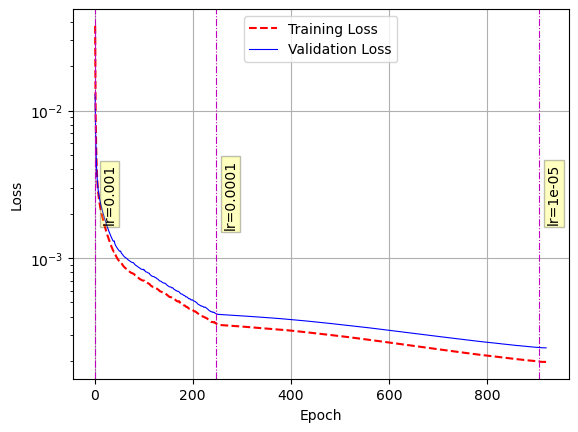

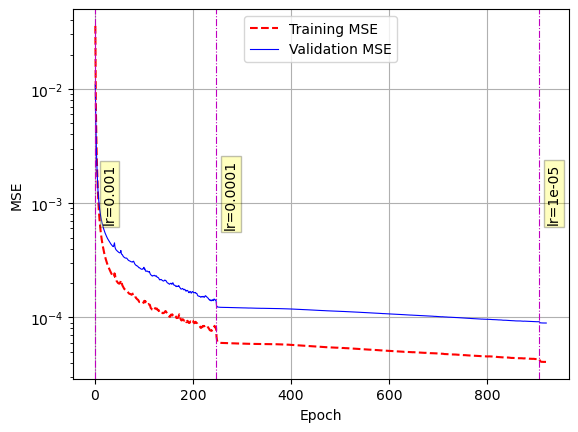

<Figure size 640x480 with 0 Axes>

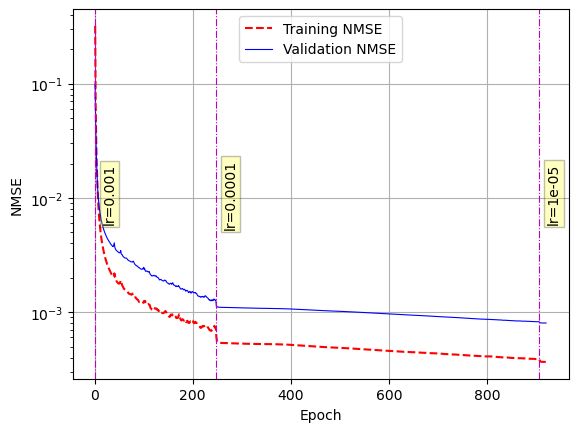

<Figure size 640x480 with 0 Axes>

In [37]:
# plotting losses
dir_name_plot = dir_name_rnn+dir_sep+'plots'
if not os.path.isdir(dir_name_plot):
    os.makedirs(dir_name_plot)

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list
)

plt.savefig(dir_name_rnn+'{ds}plots{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


fig, ax = plot_losses(
    training_loss=train_MSE_hist,
    val_loss=val_MSE_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=['Training MSE', 'Validation MSE'],
    xlabel='Epoch',
    ylabel='MSE',
)
plt.savefig(dir_name_plot+'/MSE_history.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()


fig, ax = plot_losses(
    training_loss=train_NMSE_hist,
    val_loss=val_NMSE_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=['Training NMSE', 'Validation NMSE'],
    xlabel='Epoch',
    ylabel='NMSE',
)
plt.savefig(dir_name_plot+'/NMSE_history.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()


data_idx : 52


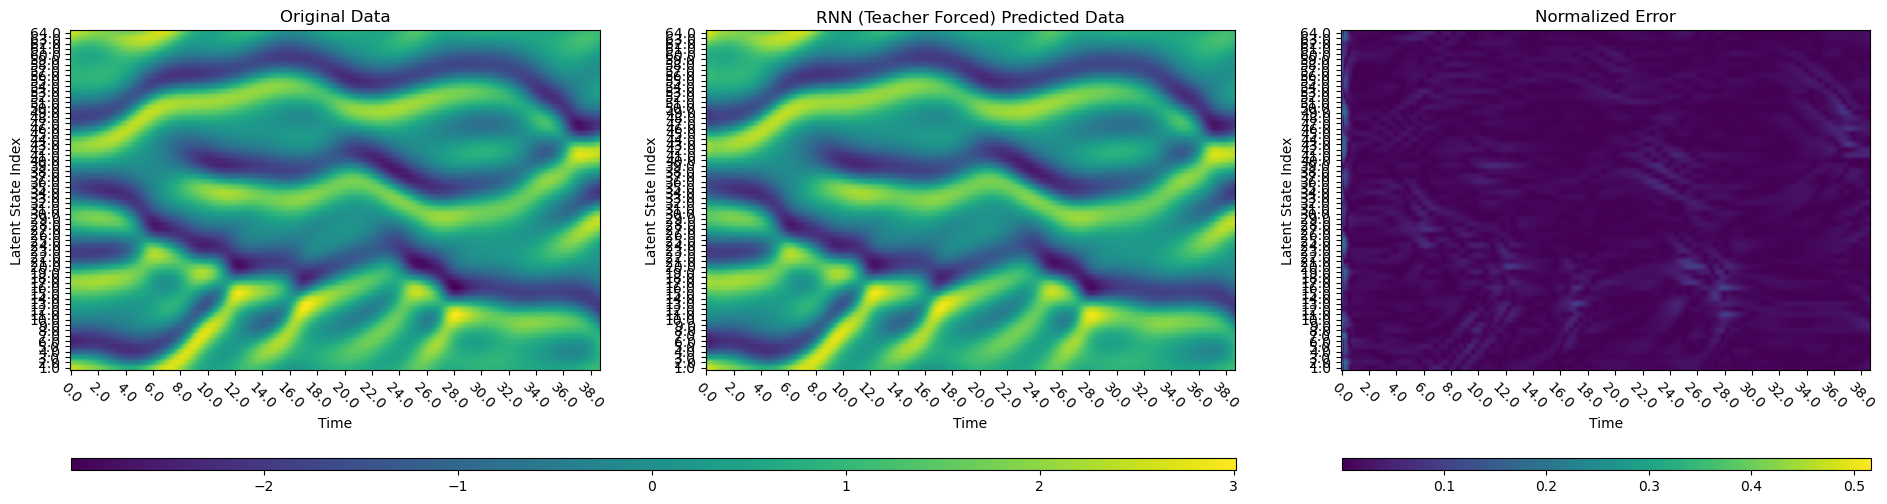

In [38]:
# data_type = 'training'
rnn_net.reset_states()
data_type = 'testing'

data_in = eval(data_type+'_data_rnn_input')
data_out = eval(data_type+'_data_rnn_output')

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 3788
print('data_idx : {}'.format(data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]

prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])

plot_reconstructed_data_KS(
    [data_out.shape[0]],
    dir_name_ae,
    data_out,
    prediction[0], delta_t, 1+np.arange(0, data_out.shape[1]),
    save_figs=False,
    normalization_constant_arr=normalization_arr,
    xticks_snapto=2,
    num_yticks=data_out.shape[1],
    ylabel=r'Latent State Index',
    ax1_title=r'Original Data',
    ax2_title=r'RNN (Teacher Forced) Predicted Data')

In [39]:
prediction.shape, data_out.shape, rnn_net.stateful

((64, 387, 64), (387, 64), True)

In [40]:
def rescale_data(data, normalization_arr):
    '''
    data - [num_batches x num_timesteps x num_states]
    normalization_arr = [2 x num_states]
    '''
    new_data = data.copy()
    shape = new_data.shape
    for i in range(data.shape[-1]):
        new_data[:, i] -= normalization_arr[0, i]
        new_data[:, i] /= normalization_arr[1, i]

    return new_data

def norm_sq_time_average(data):
    data_norm_sq = np.zeros(shape=data.shape[0])
    for i in range(data.shape[1]):
        data_norm_sq[:] += data[:, i]**2
    # integrating using the trapezoidal rule
    norm_sq_time_avg = np.sum(data_norm_sq) - 0.5*(data_norm_sq[0]+data_norm_sq[-1])
    norm_sq_time_avg /= data_norm_sq.shape[0]
    return norm_sq_time_avg

def invert_normalization(data, normalization_arr):
    new_data = np.empty_like(data)
    shape = new_data.shape
    print(shape)
    for i in range(shape[-1]):
        if len(shape) == 2:
            new_data[:, i] = data[:, i]
            new_data[:, i] *= normalization_arr[1, i]
            new_data[:, i] += normalization_arr[0, i]
        elif len(shape) == 3:
            new_data[:, :, i] = data[:, :, i]
            new_data[:, :, i] *= normalization_arr[1, i]
            new_data[:, :, i] += normalization_arr[0, i]
    return new_data

case 1, data_idx : 26


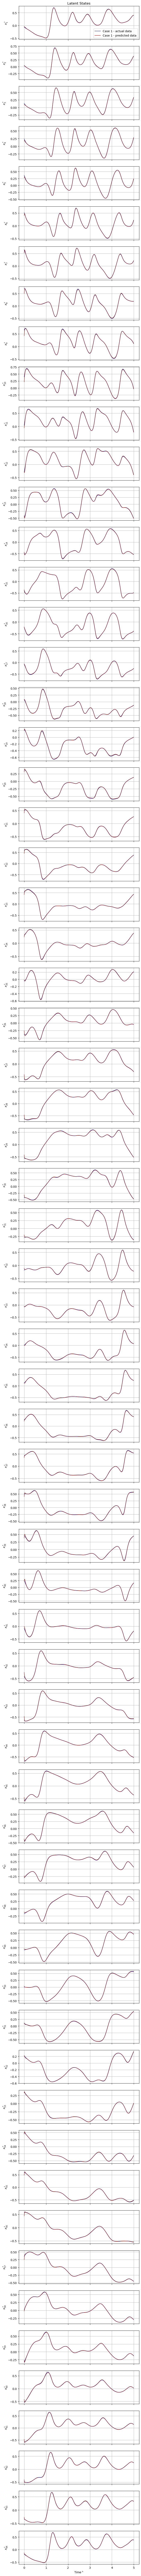


4.991497332033017


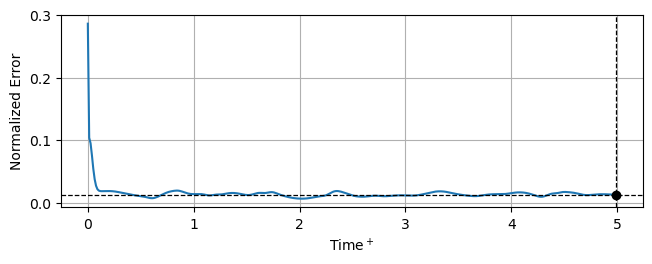

In [41]:
if rnn_net.stateful == True:
    for rnn_layer in rnn_net.rnn_list:
        rnn_layer.reset_states()


data_in = testing_data_rnn_input
data_out = testing_data_rnn_output

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 11269
for i in range(len(rnn_data_boundary_idx_arr)):
    if data_idx < rnn_data_boundary_idx_arr[i]:
        case_idx = i
        break
lyap_time = lyapunov_time_arr[case_idx]

print('case {}, data_idx : {}'.format(case_idx+1, data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]
# data_out = rescale_data(data_out, normalization_arr)
# data_out = invert_normalization(data_out, normalization_arr)

prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])
# prediction = rnn_net(data_in[data_idx:data_idx+1, :, :], training=False)
# prediction = rnn_net.call(data_in[data_idx:data_idx+1, :, :], training=False)
# prediction = invert_normalization(prediction, normalization_arr)

n = 1
num_latent_states = data_out.shape[-1]
N = data_out.shape[0]

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = ['$x^*_{' +str(i)+'}$' for i in range(1, num_latent_states+1)]

fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]
input_time = np.arange(0, N)*dt_rnn/lyap_time

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

mpl_ax_artist_list = []
for j in range(num_latent_states):
    for i in range(n):
        obj_in = ax[j].plot(input_time, data_out[:, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        obj_out = ax[j].plot(input_time, prediction[0, :, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
        mpl_ax_artist_list.append(obj_in[0])
        mpl_ax_artist_list.append(obj_out[0])
    ax[j].set_ylabel(ax_ylabels[j])
    # if xlim is not None:
    #     ax[j].set_xlim(xlim)
    # if ylim is not None:
    #     ax[j].set_ylim(ylim)
    ax[j].grid(True)
    ax[j].set_axisbelow(True)


ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
ax[0].legend(
    loc='best',
    ncol=ncols,
)
ax[0].set_title(r'Latent States', size=12)
plt.show()
# plt.savefig('AR-GRU.png', dpi=300, bbox_inches='tight')
print('')

### Error and prediction horizon
# error = np.linalg.norm(data_out[:, :] - prediction[0, :, :], axis=1)
error = (data_out[:, :] - prediction[0, :, :])**2
# error /= norm_sq_time_average(data_out)**0.5
error = np.mean(np.divide(error, time_stddev**2), axis=1)**0.5

# print(norm_sq_time_average(data_out)**0.5)

fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
ax2.plot(input_time, error)
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_xlabel('Time$^+$')
ax2.set_ylabel('Normalized Error')

error_threshold = 0.5

predhor_idx = np.where(error >= error_threshold)[0]
if predhor_idx.shape[0] == 0:
    predhor_idx = error.shape[0]-1
else:
    predhor_idx = predhor_idx[0]
ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')

prediction_horizon = predhor_idx*dt_rnn/lyap_time
print(prediction_horizon)

plt.show()

In [42]:
normalization_arr

array([[0.10489706, 0.100678  , 0.10145642, 0.1070383 , 0.11552436,
        0.12449633, 0.13209143, 0.13752756, 0.14115717, 0.14410338,
        0.14752339, 0.15166698, 0.15496776, 0.1540054 , 0.14541443,
        0.12892444, 0.1086753 , 0.09115538, 0.08146536, 0.0809811 ,
        0.08770704, 0.09816889, 0.10895358, 0.11730357, 0.12156466,
        0.12180525, 0.11966519, 0.11702383, 0.114843  , 0.11334164,
        0.11268076, 0.11299132, 0.1140624 , 0.11549318, 0.11718571,
        0.1195337 , 0.12313365, 0.12842654, 0.13557358, 0.14423496,
        0.15290101, 0.158539  , 0.15779652, 0.14940815, 0.13564833,
        0.12129505, 0.11101429, 0.10734908, 0.11033313, 0.118104  ,
        0.12774001, 0.1362438 , 0.14159964, 0.14340153, 0.1426329 ,
        0.14072081, 0.13859709, 0.13645458, 0.1341783 , 0.13177916,
        0.12913828, 0.12547515, 0.11978355, 0.1122352 ],
       [3.8727334 , 3.8825111 , 3.891457  , 3.8898184 , 3.8783908 ,
        3.8647516 , 3.8535602 , 3.8457823 , 3.843356  , 3.8

# Autoregressive Mode

In [43]:
# s_in = testing_data_rnn_input.shape
# testing_data_rnn_input = testing_data_rnn_input.reshape((1, s_in[0]*s_in[1]) + s_in[2:])
# # testing_data_rnn_input = testing_data_rnn_input.reshape((s_in[0], s_in[1]) + s_in[2:])

# s_out = testing_data_rnn_output.shape
# testing_data_rnn_output = testing_data_rnn_output.reshape((1, s_out[0]*s_out[1]) + s_out[2:])
# # testing_data_rnn_output = testing_data_rnn_output.reshape((s_out[0], s_out[1]) + s_out[2:])

In [44]:
temp1 = np.empty_like(testing_data_rnn_input)
temp2 = np.empty_like(testing_data_rnn_output)

begin_idx = 0
testing_data_rolling_count = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    # num_samples = idx.shape[0]
    # num_train = int( (1-test_split-val_split)*num_samples )
    # num_val = int(val_split*num_samples)
    num_samples = num_samples_arr[i]
    num_test = num_test_arr[i]

    nbatches_test = num_test // batch_size

    for j in range(batch_size):
        temp1[testing_data_rolling_count + j*nbatches_test:testing_data_rolling_count + (j+1)*nbatches_test] = testing_data_rnn_input[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size]
        temp2[testing_data_rolling_count + j*nbatches_test:testing_data_rolling_count + (j+1)*nbatches_test] = testing_data_rnn_output[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size]

    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

In [45]:
testing_data_rnn_input_og = testing_data_rnn_input
testing_data_rnn_output_og = testing_data_rnn_output

testing_data_rnn_input = temp1
testing_data_rnn_output = temp2

In [46]:
s_in = testing_data_rnn_input.shape
testing_data_rnn_input = testing_data_rnn_input.reshape((1, s_in[0]*s_in[1]) + s_in[2:])
# testing_data_rnn_input = testing_data_rnn_input.reshape((s_in[0], s_in[1]) + s_in[2:])

s_out = testing_data_rnn_output.shape
testing_data_rnn_output = testing_data_rnn_output.reshape((1, s_out[0]*s_out[1]) + s_out[2:])
# testing_data_rnn_output = testing_data_rnn_output.reshape((s_out[0], s_out[1]) + s_out[2:])

In [47]:
T_sample_input_AR = 1*np.mean(lyapunov_time_arr)#50.1*dt_rnn
num_sample_input_AR = int((T_sample_input_AR+0.5*dt_rnn)//dt_rnn)

T_sample_output_AR = 10*np.mean(lyapunov_time_arr)
num_sample_output_AR = int((T_sample_output_AR+0.5*dt_rnn)//dt_rnn)

num_offset_AR = num_sample_input_AR
T_offset_AR = num_offset_AR*dt_rnn

batch_idx : 0
data_idx : 2454
data_.shape : (1, 850, 64)


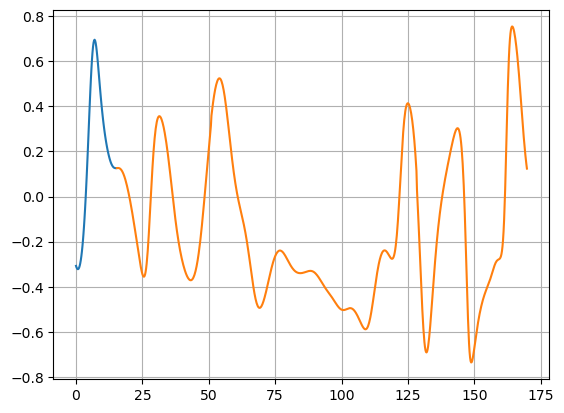

In [48]:
# data_to_consider = 'training'
data_to_consider = 'testing'

data_in = eval(data_to_consider+'_data_rnn_input')
data_out = eval(data_to_consider+'_data_rnn_output')

batch_idx = np.random.randint(low=0, high=data_in.shape[0])
maxpossible_num_runs = data_in.shape[1]-(num_sample_input_AR+num_sample_output_AR)

data_idx = np.random.randint(low=0, high=maxpossible_num_runs)

print('batch_idx : {}'.format(batch_idx))
print('data_idx : {}'.format(data_idx))
data_ = data_in[batch_idx:batch_idx+1, data_idx:data_idx+(num_sample_input_AR+num_sample_output_AR), :]
print('data_.shape :', data_.shape)

plt.plot(dt_rnn*np.arange(num_sample_input_AR), data_[0, 0:num_sample_input_AR, 0])
plt.plot(dt_rnn*num_sample_input_AR+dt_rnn*np.arange(num_sample_output_AR), data_[0, num_sample_input_AR:, 0])
plt.grid(True)
plt.show()

In [49]:
prediction_lst = []

for layer in rnn_net.rnn_list:
    if layer.stateful == True:
        layer.reset_states()

    if data_.shape[0] != batch_size:
        data_ = np.tile(data_, (batch_size, 1, 1))
input_preds = np.array(rnn_net(data_[:, 0:num_sample_input_AR, :]))

prediction_lst.append(input_preds[:, -2:-1, :])

for i in range(1, num_sample_output_AR):
    data_in_i = np.array(prediction_lst[-1])
    output = np.array(rnn_net(data_in_i, training=False))
    prediction_lst.append(output[:, 0:1, :])

In [50]:
prediction_lst = np.stack(prediction_lst)
prediction_lst = np.squeeze(prediction_lst)
if rnn_net.stateful == True:
    prediction_lst = np.transpose(prediction_lst, [1, 0, 2])
# print(np.squeeze(prediction_lst).shape)
# print(np.transpose(prediction_lst, [1, 0, 2]).shape)

print('input_preds.shape : {}'.format(input_preds.shape))
print('prediction_lst.shape : {}'.format(prediction_lst.shape))

input_preds.shape : (64, 77, 64)
prediction_lst.shape : (64, 773, 64)


In [51]:
data_ = data_[0:1]
if rnn_net.stateful == True:
    prediction_lst = prediction_lst[0]
input_preds = input_preds[0]

0.5560476302523827


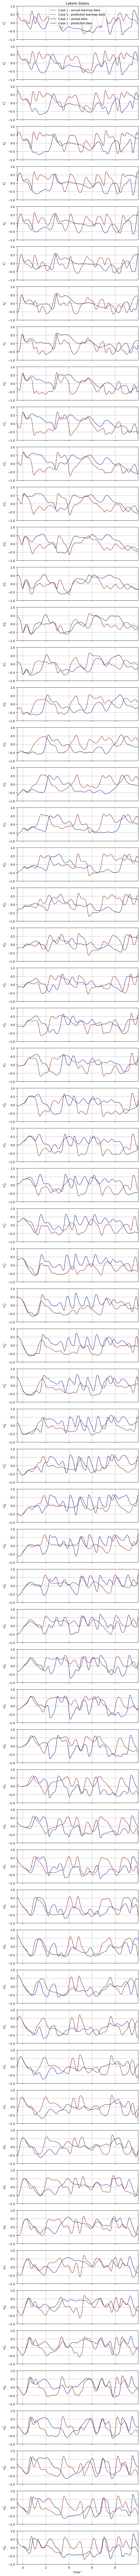

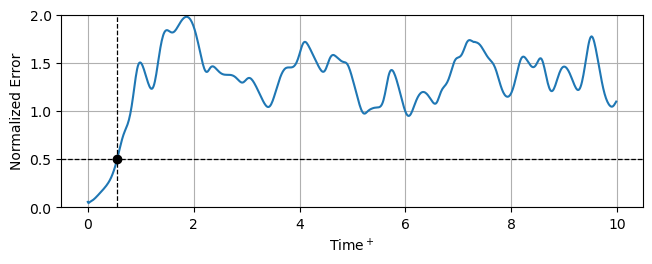

In [52]:
lyap_time = np.mean(lyapunov_time_arr)

n = 1
num_latent_states = input_preds.shape[-1]
N = num_sample_output_AR#num_output_timesteps

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = [r'$x^*_{'+str(i+1)+'}$' for i in range(num_latent_states)]

fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

time_arr_warmup1 = (np.arange(num_sample_input_AR) - num_sample_input_AR)*dt_rnn
time_arr_warmup2 = time_arr_warmup1 + dt_rnn

time_arr_warmup1 /= lyap_time
time_arr_warmup2 /= lyap_time

input_time = time_arr_warmup2[-1]+np.arange(N, dtype=float)*dt_rnn/lyap_time

for j in range(num_latent_states):
    for i in range(n):
        ax[j].plot(time_arr_warmup1, data_[0, 0:num_sample_input_AR, j], linestyle='--', linewidth=1, color=colors[2*i], label='Case {} - actual warmup data'.format(i+1))
        ax[j].plot(time_arr_warmup2, input_preds[:, j], linestyle='--', linewidth=1, color=colors[2*i+1], label='Case {} - predicted warmup data'.format(i+1))
        ax[j].plot(input_time, data_[0, num_sample_input_AR:num_sample_input_AR+N, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        ax[j].plot(input_time, prediction_lst[:, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
    ax[j].set_ylabel(ax_ylabels[j])
    ax[j].grid(True)
    ax[j].set_axisbelow(True)
    ax[j].set_ylim([-1, 1])
    ax[j].set_xlim([input_time[0] - 0.5, input_time[-1]])


ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
ax[0].legend(
    loc='best',
    ncol=ncols,
)
ax[0].set_title(r'Latent States', size=12)


### error computation
error = (data_[0, num_sample_input_AR:num_sample_input_AR+N, :] - prediction_lst[:, :])**2
# error /= norm_sq_time_average(data_out)**0.5
error = np.mean(np.divide(error, time_stddev**2), axis=1)**0.5

# print(norm_sq_time_average(data_out)**0.5)

fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
ax2.plot(input_time, error)
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_xlabel('Time$^+$')
ax2.set_ylabel('Normalized Error')

error_threshold = 0.5

predhor_idx = np.where(error >= error_threshold)[0]
if predhor_idx.shape[0] == 0:
    predhor_idx = error.shape[0]-1
else:
    predhor_idx = predhor_idx[0]
ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.set_ylim([0, 2])

prediction_horizon = predhor_idx*dt_rnn/lyap_time
print(prediction_horizon)

In [53]:
# sp = np.array([var.numpy() for var in rnn_net.scalar_multiplier_pre_list])
# print(sp)
# sum_ = np.sum(np.exp(sp))
# print(np.exp(sp)/sum_)

In [54]:
rnn_net.dense[-1].weights

[<tf.Variable 'rnn_gru/time_distributed_1/individual_weights:0' shape=(64,) dtype=float32, numpy=
 array([1.1715741, 1.1937603, 1.339925 , 1.2412018, 1.1651832, 1.2008857,
        1.484841 , 1.1408935, 1.1158489, 1.1146865, 1.1625687, 1.183074 ,
        1.1057128, 1.3190223, 1.8349292, 1.2138863, 1.1594205, 1.1827241,
        1.1435033, 1.1228606, 1.1396514, 1.1626394, 1.2839957, 1.1664662,
        1.1745536, 1.1610891, 1.1458706, 1.1770651, 1.2422726, 1.1601404,
        1.2341886, 1.1656045, 1.1611314, 1.1490538, 1.1515671, 1.1498188,
        1.1893421, 1.1786169, 1.1442313, 1.2634286, 1.1276367, 1.1664824,
        1.2495452, 1.100867 , 1.0907227, 1.1625199, 1.1587765, 1.0934391,
        1.2398164, 1.1902031, 1.2574658, 1.1811289, 1.1380384, 1.1842542,
        1.1502181, 1.1331468, 1.1443051, 1.1651807, 1.1844211, 0.9481827,
        1.1355735, 1.1649921, 1.1763585, 1.1433645], dtype=float32)>]

In [55]:
if 'use_trainable_weights_with_reslayers' in rnn_net.__dict__.keys():
    if use_trainable_weights_with_reslayers == True:
        for i in range(rnn_net.num_skip_connections):
            print('reslayer_factor_{} : {}'.format(i, rnn_net.reslayer_factor[i]))